In [2]:
import pandas as pd
import numpy as np
import os
import sys
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_squared_error, r2_score
import os.path
from skorch import NeuralNetRegressor
from torch import nn, optim
from skorch.callbacks import EarlyStopping
from skorch.callbacks import EpochScoring
import matplotlib.pyplot as plt
import pickle
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso

# Define the current directory if __file__ is not available
current_dir = os.getcwd()  # Gets the current working directory
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))  # Moves one level up

# Add the parent directory to the Python path
sys.path.insert(0, parent_dir)

from preprocessing import *

c:\Users\paola\anaconda3\envs\MLCourse\lib\site-packages\dask\dataframe\__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [3]:
# Define the path to the parent directory
data_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))  # Move one level up

In [27]:
X_file = os.path.join(data_dir, "X_matrix__YPD_doublingtime_restricted.pkl")
Y_file = os.path.join(data_dir, "data/Y_matrix.csv")


x2_df = pd.read_pickle(os.path.join(data_dir, "data/X_matrix__YPD_doublingtime_restricted.pkl"))

print("moving to y")
y2_df = pd.read_csv(Y_file)
print("three")


x_data_f = x2_df.drop(x2_df.columns[0], axis=1)
y_data_f = y2_df.drop(y2_df.columns[0], axis=1)

x_data_f, y_data_f = shuffle_dataset(x_data_f, y_data_f)




moving to y
three


In [28]:

# Number of input features
n_input_features = x_data_f.shape[1]

# Enhanced Neural Network with More Layers and Neurons
class EnhancedRegressionNet(nn.Module):
    def __init__(self, n_input_features, dropout_rate, n_neurons_1=1024, n_neurons_2=512, n_neurons_3=256, n_neurons_4=256):
        super(EnhancedRegressionNet, self).__init__()
        self.fc1 = nn.Linear(n_input_features, n_neurons_1)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_rate)

        self.fc2 = nn.Linear(n_neurons_1, n_neurons_2)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout_rate)

        self.fc3 = nn.Linear(n_neurons_2, n_neurons_3)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(dropout_rate)

        self.fc5 = nn.Linear(n_neurons_3, 1)  # Output layer remains the same

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.dropout1(x)

        x = self.relu2(self.fc2(x))
        x = self.dropout2(x)

        x = self.relu3(self.fc3(x))
        x = self.dropout3(x)

        x = self.fc5(x)
        return x

# Ensure both x_data_f and y_data_f are converted to float32
x_data_f = x_data_f.astype(np.float32)  # Cast features to float32
y_data_f = y_data_f.astype(np.float32)  # Cast target to float32

# Define scoring callbacks for training and validation loss
train_loss = EpochScoring(scoring='neg_mean_squared_error', on_train=True, name='train_loss', lower_is_better=False)
valid_loss = EpochScoring(scoring='neg_mean_squared_error', name='valid_loss', lower_is_better=False)

# Neural Network Regressor
net = NeuralNetRegressor(
    module=EnhancedRegressionNet,
    module__n_input_features=n_input_features,  # n_input_features
    criterion=nn.MSELoss,
    optimizer=optim.Adam,
    optimizer__weight_decay=1e-5,  # L2 regularization
    iterator_train__shuffle=True,
    iterator_train__batch_size=32,
    callbacks=[EarlyStopping(patience=5)],
    verbose=1
)

# Parameter grid
param_grid = {
    'module__dropout_rate': [0.01, 0.1, 0.2],
    'lr': [ 0.0001, 0.00001],
    'max_epochs': [100, 150]
}

# GridSearchCV
grid_search = GridSearchCV(net, param_grid=param_grid, cv=KFold(n_splits=5), scoring='neg_mean_squared_error', n_jobs=2)

In [29]:
y_data_f = y_data_f.to_numpy()
print(y_data_f.shape)

(792, 1)


In [ ]:
# NO NEED TO RUN, the best parameters are saved

# Fit the grid search
grid_search.fit(x_data_f.values, y_data_f)

# Get the best parameters from the grid search
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

In [30]:
best_params = {
    'module__dropout_rate': 0.3,  # Single value for dropout rate
    'lr': 0.0001,                # Single value for learning rate
    'max_epochs': 150            # Single value for max epochs
}

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1       -0.0601       -0.0821  0.4884
      2       -0.0504       -0.0844  0.4506
      3       -0.0442       -0.0827  0.4461
      4       -0.0432       -0.0852  0.4378
      5       -0.0407       -0.0809  0.4199
      6       -0.0404       -0.0811  0.4263
      7       -0.0402       -0.0818  0.4164
      8       -0.0397       -0.0803  0.5030
      9       -0.0387       -0.0829  0.4690
     10       -0.0363       -0.0796  0.4619
     11       -0.0365       -0.0810  0.4161
     12       -0.0346       -0.0793  0.4091
     13       -0.0350       -0.0804  0.4499
     14       -0.0335       -0.0795  0.4865
     15       -0.0332       -0.0833  0.4209
     16       -0.0312       -0.0791  0.4040
     17       -0.0309       -0.0835  0.4340
     18       -0.0303       -0.0790  0.4457
     19       -0.0298       -0.0805  0.4736
     20       -0.0272       -0.0788  0.5019
     21       -0.0261       -0.0

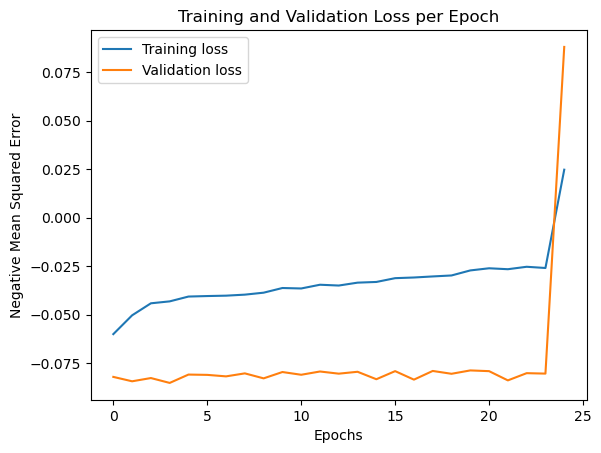

In [31]:
# V3 : add L2 regularization

from skorch import NeuralNetRegressor
from torch import nn, optim
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Training of the Model with More Complexity and L2 Regularization
best_net2 = NeuralNetRegressor(
    module=EnhancedRegressionNet,
    module__n_input_features=n_input_features,
    module__n_neurons_1=2048,
    module__n_neurons_2=1024,                  
    module__n_neurons_3=512,
    #module__n_neurons_4=256,
    module__dropout_rate=best_params['module__dropout_rate'],
    criterion=nn.MSELoss,
    max_epochs=best_params['max_epochs'],
    optimizer=optim.Adam,
    lr=best_params['lr'],
    optimizer__weight_decay=5e-4,              # L2 regularization (Weight Decay)
    iterator_train__shuffle=True,
    callbacks=[EarlyStopping(patience=5), train_loss, valid_loss],
    verbose=1
)

# Train the Final Model
best_net2.fit(x_data_f.values, y_data_f)

# Predictions
Y_pred = best_net2.predict(x_data_f.values)

# Reshape Predictions (if needed)
Y_pred = Y_pred.reshape(-1, 1)

# Evaluate the Model
mse = mean_squared_error(y_data_f, Y_pred)
print(f'Mean Squared Error: {mse}')
r2 = r2_score(y_data_f, Y_pred)
print(f'R2 score: {r2}')

# Extract Training and Validation Loss
train_losses = best_net2.history[:, 'train_loss']
valid_losses = best_net2.history[:, 'valid_loss']

# Plot Training and Validation Loss
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Negative Mean Squared Error')
plt.title('Training and Validation Loss per Epoch')
plt.legend()
plt.show()

In [32]:
trained_nn = best_net2

# Use the NN to generate predictions
#y_pred = trained_nn.predict(x_data_f.values)
y_pred = Y_pred

# Train a Random Forest on the original input features
rf = RandomForestRegressor(max_depth=40, 
                           max_features='sqrt', 
                           min_samples_leaf = 4, 
                           n_estimators=500, 
                           random_state=42)
rf.fit(x_data_f, y_pred)

# Display feature importances from Random Forest
importances = rf.feature_importances_
for feature_name, importance in zip(x_data_f.columns, importances):
    print(f"Feature: {feature_name}, Importance: {importance}")


c:\Users\paola\anaconda3\envs\MLCourse\lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Feature: YAL016C-A_10_T->I, Importance: 0.0
Feature: YAL016C-A_29_N->S, Importance: 7.30665830894222e-06
Feature: YAL016C-A_31_S->P, Importance: 0.0008248380831103057
Feature: YAL016C-A_33_E->G, Importance: 1.4922401731152883e-05
Feature: YAL016C-A_35_E->K, Importance: 0.0
Feature: YAL016C-A_43_D->G, Importance: 0.00032312152119581003
Feature: YAL016C-A_55_P->L, Importance: 4.8614837138686096e-05
Feature: YAL016C-A_65_F->S, Importance: 0.0
Feature: YAL016C-A_68_F->C, Importance: 0.0
Feature: YAL016C-A_70_T->S, Importance: 2.632425379066172e-05
Feature: YAL016C-A_79_I->M, Importance: 0.0
Feature: YAL016C-A_81_V->I, Importance: 0.0
Feature: YAL016C-A_89_S->C, Importance: 0.0
Feature: YAL016C-A_89_S->Y, Importance: 1.607703253729208e-06
Feature: YAL016C-A_90_T->K, Importance: 0.0
Feature: YAL016C-A_97_A->V, Importance: 0.00024519179145890565
Feature: YAL016C-A_99_L->F, Importance: 0.00041072020942517794
Feature: YAL016C-A_99_L->I, Importance: 0.0007717879533102319
Feature: YAL020C_107_R->

In [33]:
# Save the feature importances in a CSV
importances_df = pd.DataFrame({
    'Feature': x_data_f.columns,
    'Importance': importances
})

# Sort the DataFrame by 'Importance' in descending order
importances_df = importances_df.sort_values(by='Importance', ascending=False)

# Save the sorted DataFrame to a CSV file
importances_df.to_csv('../results/mutations_NNrestricted_importance.csv', index=False)

print("Feature importances saved in descending order of importance.")


Feature importances saved in descending order of importance.


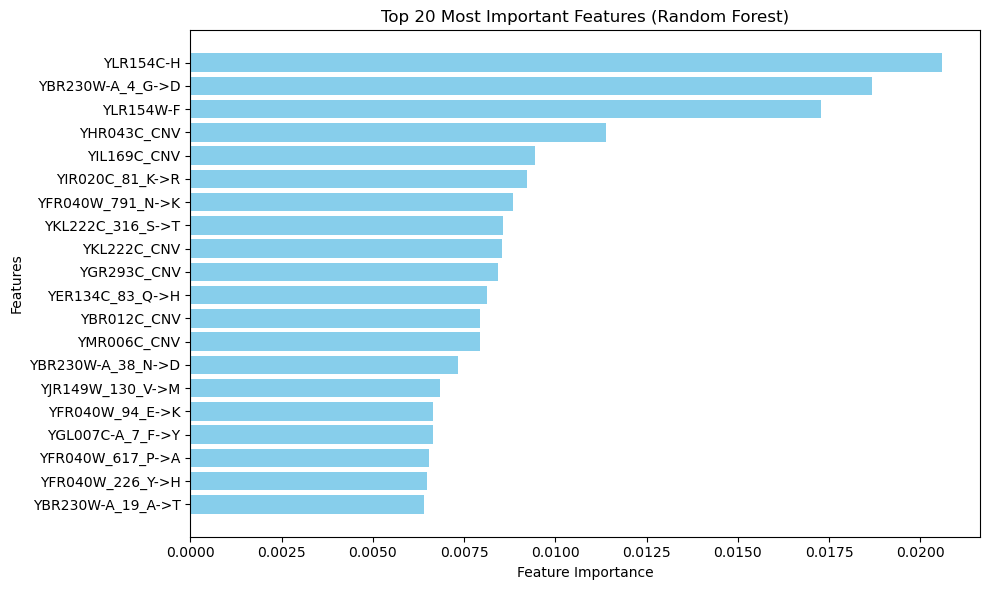

In [34]:
import matplotlib.pyplot as plt
import numpy as np

# Extract feature importances and names
feature_importances = rf.feature_importances_
feature_names = x_data_f.columns

# Combine feature names and their importances
features = list(zip(feature_names, feature_importances))

# Sort features by importance in descending order
sorted_features = sorted(features, key=lambda x: x[1], reverse=True)

# Select the top 20 most important features
top_20_features = sorted_features[:20]

# Split into names and values for plotting
top_20_names, top_20_values = zip(*top_20_features)

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.barh(top_20_names, top_20_values, color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Top 20 Most Important Features (Random Forest)')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature on top
plt.tight_layout()
plt.show()
